In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [25]:
def load_model(network, sparse_method, dataset, hyp_name, hype_value, sparse_thr):
    import os
    ckpt_name = f"runs/{network}-{sparse_method}-{dataset}/{hyp_name}={hype_value}/prune_rate=0.0/0/checkpoints/model_best.pth"
    if os.path.exists(ckpt_name):
        load_dict = torch.load(ckpt_name)
    else:
        ckpt_name = f"runs/{network}-{sparse_method}-{dataset}/{hyp_name}={hype_value}/prune_rate=0.0/checkpoints/model_best.pth"
        load_dict = torch.load(ckpt_name)
        
    parameter_dict = load_dict['state_dict']
    best_test_acc1 = load_dict['best_acc1']
    total = 0
    nonzero = 0
    for k, v in parameter_dict.items():
        total += v.numel()
        nonzero += (v > sparse_thr).float().sum()
    comp_ratio = total / nonzero
    return comp_ratio.item(), best_test_acc1
    

In [29]:
load_model('resnet18', 'l1', 'cifar10', 'l1', '3e-3', 1e-3)

(23.63456916809082, 10.0)

In [30]:
hypvalue = "1e-5 3e-5 1e-4 3e-4 1e-3".split()
x = []
y = []
for hypv in hypvalue:
    _x, _y = load_model('resnet18', 'l1', 'cifar10', 'l1', hypv, 1e-3)
    x.append(_x)
    y.append(_y)
l1_cifar10_xy = [x, y]

x = []
y = []
for hypv in hypvalue:
    _x, _y = load_model('resnet18', 'l1', 'cifar100', 'l1', hypv, 1e-3)
    x.append(_x)
    y.append(_y)
l1_cifar100_xy = [x, y]

In [31]:
print(l1_cifar100_xy)

[[7.4064106941223145, 38.75770950317383, 306.9721984863281, 2963.431396484375, 17951.009765625], [76.44, 72.8, 56.07, 28.99, 11.81]]


In [32]:
str_cifar10_spar = [8.95e-6, 97.62, 97.67, 99.54, 99.93]
str_cifar10_xy = [
    [100 / (100 - s) for s in str_cifar10_spar],
    [97.15, 94.32, 93.44, 83.04, 64.67],
]

str_cifar100_spar = [95.73,99.03,99.64,99.98]
str_cifar100_xy = [
    [100 / (100 - s) for s in str_cifar100_spar],
    [82.15,58.62,40.74,5.48],
]

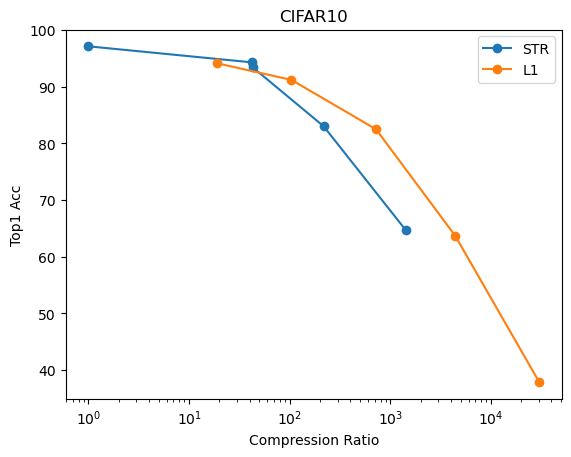

In [8]:
x, y = str_cifar10_xy
plt.plot(x, y, label="STR", marker='o')
x, y = l1_cifar10_xy
plt.plot(x, y, label="L1", marker='o')
plt.legend()
plt.xscale('log')
plt.title("CIFAR10")
plt.ylabel("Top1 Acc")
plt.xlabel("Compression Ratio")
plt.show()

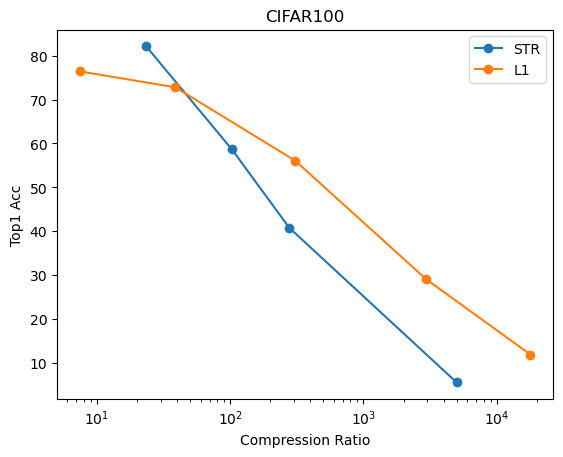

In [9]:
x, y = str_cifar100_xy
plt.plot(x, y, label="STR", marker='o')
x, y = l1_cifar100_xy
plt.plot(x, y, label="L1", marker='o')
plt.legend()
plt.xscale('log')
plt.title("CIFAR100")
plt.ylabel("Top1 Acc")
plt.xlabel("Compression Ratio")
plt.show()

In [95]:
import torch
import os

from torchvision import datasets, transforms

from model_eval.resnet_eval import ResNet18

from utils.logging import AverageMeter
from utils.eval_utils import accuracy
import tqdm

class CIFAR10:
    def __init__(self):

        data_root = os.path.join("rawdata", "cifar10")

        use_cuda = torch.cuda.is_available()

        # Data loading code
        kwargs = {"num_workers": 20, "pin_memory": True} if use_cuda else {}


        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )

        train_dataset = datasets.CIFAR10(
            data_root,
            True,
            transforms.Compose(
                [
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    normalize,
                ]
            ),
            download=True
        )

        self.train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=256, shuffle=True, **kwargs
        )

        self.val_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10(
                data_root,
                False,
                transforms.Compose(
                    [
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        normalize,
                    ]
                ),
                download=True
            ),
            batch_size=256,
            shuffle=False,
            **kwargs
        )


class CIFAR100:
    def __init__(self):

        data_root = os.path.join("rawdata", "cifar10")

        use_cuda = torch.cuda.is_available()

        # Data loading code
        kwargs = {"num_workers": 20, "pin_memory": True} if use_cuda else {}


        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )

        train_dataset = datasets.CIFAR100(
            data_root,
            True,
            transforms.Compose(
                [
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    normalize,
                ]
            ),
            download=True
        )

        self.train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=256, shuffle=True, **kwargs
        )

        self.val_loader = torch.utils.data.DataLoader(
            datasets.CIFAR100(
                data_root,
                False,
                transforms.Compose(
                    [
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        normalize,
                    ]
                ),
            ),
            batch_size=256,
            shuffle=False,
            **kwargs
        )

        
cifar10_dataset = CIFAR10()
cifar100_dataset = CIFAR100()

def evaluate_checkpoint(ckpt_path = "runs/resnet18-l1-cifar10/l1=1e-3/prune_rate=0.0/0/checkpoints/model_best.pth",
                        dataset = "cifar10",
                        conv_type = "vanilla",
                        thr = 1e-3,
                        device="cuda:0",
                        num_classes=100):

    model = ResNet18(conv_type=conv_type,num_classes=num_classes)
    state_dict = torch.load(ckpt_path)
    model_state_dict = {}

    for k, v in state_dict['state_dict'].items():
        model_state_dict[k[7:]] = v

    model.load_state_dict(model_state_dict)

    for n, m in model.named_modules():
        if hasattr(m, 'thr'):
            m.thr = thr
            print("setting threshold", n)

    data = cifar10_dataset if dataset == 'cifar10' else cifar100_dataset
    val_loader = data.val_loader

    top1 = AverageMeter("Acc@1", ":6.2f", write_val=False)
    top5 = AverageMeter("Acc@5", ":6.2f", write_val=False)
    # switch to evaluate mode
    model.eval()

    model.to(device)

    with torch.no_grad():
        for i, (images, target) in tqdm.tqdm(
            enumerate(val_loader), ascii=True, total=len(val_loader)
        ):
            images = images.to(device)
            target = target.to(device).long()

            # compute output
            output = model(images)


            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            top1.update(acc1.item(), images.size(0))
            top5.update(acc5.item(), images.size(0))

    acc = top1.avg

    nonzero_sum, total_sum = 0, 0
    for n, m in model.named_modules():
        if hasattr(m, 'getSparsity'):
            nonzero, total, _= m.getSparsity(thr)
            nonzero_sum += nonzero
            total_sum += total
    compression_ratio = total_sum / nonzero_sum

    # return {"acc": acc, "cr": compression_ratio.item()}
    return compression_ratio.item(), acc

evaluate_checkpoint(
ckpt_path = "runs/resnet18-spared-cifar100/weight_decay=3e-4/prune_rate=0.0/checkpoints/model_best.pth",
dataset = "cifar100",
conv_type = "VanillaConv1",
thr = 1e-3,
device="cuda:0",
num_classes=100
)

In [52]:
ckpt_path = "runs/resnet18-l1-cifar10/l1=1e-3/prune_rate=0.0/0/checkpoints/model_best.pth"
dataset = "cifar10"
conv_type = "vanilla"
thr = 1e-3
device="cuda:0"

In [105]:

evaluate_checkpoint(ckpt_path = "runs/resnet18-spared-cifar10/weight_decay=3e-3/prune_rate=0.0/checkpoints/model_best.pth",
                    dataset = "cifar10",
                    conv_type = "vanilla",
                    thr = 2e-3,
                    device="cuda:0",
                    num_classes=10)

setting threshold conv1
setting threshold layer1.0.conv1
setting threshold layer1.0.conv2
setting threshold layer1.1.conv1
setting threshold layer1.1.conv2
setting threshold layer2.0.conv1
setting threshold layer2.0.conv2
setting threshold layer2.0.downsample.0
setting threshold layer2.1.conv1
setting threshold layer2.1.conv2
setting threshold layer3.0.conv1
setting threshold layer3.0.conv2
setting threshold layer3.0.downsample.0
setting threshold layer3.1.conv1
setting threshold layer3.1.conv2
setting threshold layer4.0.conv1
setting threshold layer4.0.conv2
setting threshold layer4.0.downsample.0
setting threshold layer4.1.conv1
setting threshold layer4.1.conv2
setting threshold fc


100%|########################################################################################################################################################################################################| 40/40 [00:07<00:00,  5.61it/s]


(4700.0556640625, 50.68)